## Image Denoising

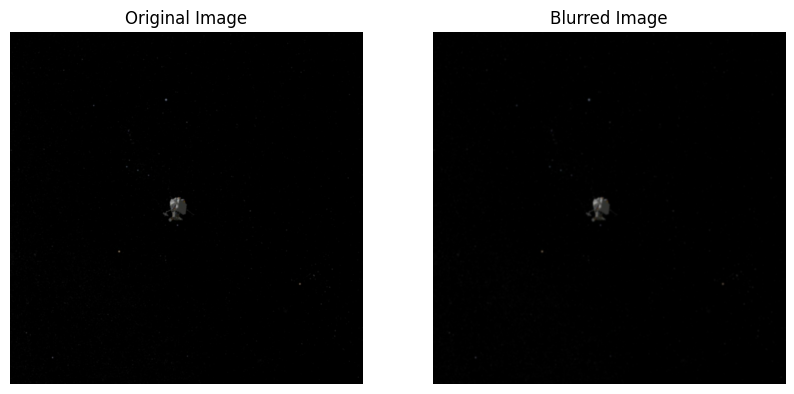

PSNR: 49.456642
SSIM: 0.99425405


In [12]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def gaussian_kernel(size: int, sigma: float):
    """Creates a 2D Gaussian kernel using TensorFlow operations."""
    d = tf.range(-size, size + 1, dtype=tf.float32)
    gauss_1d = tf.exp(-tf.square(d) / (2.0 * sigma**2))
    gauss_1d = gauss_1d / tf.reduce_sum(gauss_1d)

    # Create 2D Gaussian kernel from outer product of two 1D kernels
    gauss_2d = tf.tensordot(gauss_1d, gauss_1d, axes=0)
    return gauss_2d[..., tf.newaxis, tf.newaxis]  # Add channel dimensions

def apply_gaussian_blur(image, kernel_size=5, sigma=1.0):
    """Applies Gaussian blur to an image using a Gaussian kernel."""
    kernel = gaussian_kernel(kernel_size, sigma)
    kernel = tf.tile(kernel, [1, 1, tf.shape(image)[-1], 1])  # Apply the same kernel to each channel
    blurred_image = tf.nn.depthwise_conv2d(image[tf.newaxis, ...], kernel, strides=[1, 1, 1, 1], padding='SAME')
    return blurred_image[0]

def load_and_preprocess_image(path):
    """Loads and preprocesses the image."""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)  # Adjust 'channels' if your image is not in RGB
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float values in [0, 1]
    return image

# Replace 'path/to/your/image.jpg' with the actual path to your image
image_path = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/train/image_00013_TRMM_2021.jpg'
image = load_and_preprocess_image(image_path)

# Apply Gaussian blur to the image
blurred_image = apply_gaussian_blur(image, kernel_size=5, sigma=1.5)

# Display the original and blurred images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Blurred Image")
plt.imshow(blurred_image)
plt.axis('off')

plt.show()


psnr = tf.image.psnr(image, blurred_image, max_val=1.0)
ssim = tf.image.ssim(image, blurred_image, max_val=1.0)

print("PSNR:", psnr.numpy())
print("SSIM:", ssim.numpy())

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd


/Users/nithish/Documents/Academics/Spring 24/AML/project/Venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [15]:
# Example CSV file structure
# filename, label
# satellite001.jpg, satellite
# debris001.jpg, debris
# ...

label_path = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/labels.csv'

label = pd.read_csv(label_path)
train_df = label[label['usage'] == 'train'][['filename', 'class', 'bbox']].sample(frac = 1, random_state = 32)
val_df = label[label['usage'] == 'val'][['filename', 'class', 'bbox']].sample(frac = 1, random_state = 32)

# Assuming 'label' is the column with numerical values
train_df['class'] = train_df['class'].replace({1: 'satellite', 0: 'debris'})
val_df['class'] = val_df['class'].replace({1: 'satellite', 0: 'debris'})

print(train_df.shape)
print(val_df.shape)

label


(41999, 3)
(4000, 3)


,illumination,filename,bbox,year,usage,class
0,175.828667,image_01964_Debris_2021.jpg,"[444, 762, 581, 869]",2021,train,0.0
1,1.676628,image_05771_AcrimSat_2021.jpg,"[343, 435, 527, 627]",2021,train,1.0
2,72.953103,image_06722_AcrimSat_2021.jpg,"[286, 280, 542, 628]",2021,train,1.0
3,0.100779,image_05072_CubeSat_2021.jpg,"[209, 596, 247, 638]",2021,train,1.0
4,0.207253,image_13558_Debris_2021.jpg,"[387, 221, 425, 255]",2021,train,0.0
...,...,...,...,...,...,...
97994,NaN,img022385.png,NaN,2022,test,NaN
97995,NaN,img022129.png,NaN,2022,test,NaN
97996,NaN,img025998.png,NaN,2022,test,NaN
97997,NaN,img023907.png,NaN,2022,test,NaN


## denoising

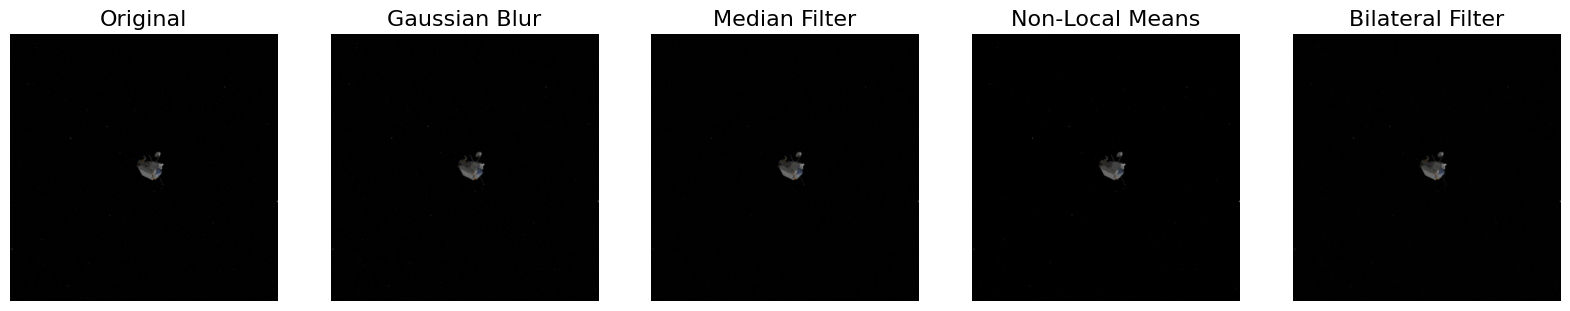

In [12]:
import cv2
import matplotlib.pyplot as plt

def load_and_apply_denoising(path):
    # Load the image in color
    image = cv2.imread(path)

    # Apply Gaussian Blur
    gaussian = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply Median Filter
    median = cv2.medianBlur(image, 5)

    # Apply Non-Local Means Denoising for color images
    non_local_means = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

    # Apply Bilateral Filter
    bilateral = cv2.bilateralFilter(image, 9, 75, 75)

    return image, gaussian, median, non_local_means, bilateral

def display_images(images, titles):
    plt.figure(figsize=(20, 12))  # Adjusted figure size for larger display
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.title(title, fontsize=16)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        plt.axis('off')
    plt.show()

# Path to your local image
image_path = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/train/image_00002_TRMM_2021.jpg'

# Load and apply denoising
original, gaussian, median, nlm, bilateral = load_and_apply_denoising(image_path)

# Display the images
display_images(
    [original, gaussian, median, nlm, bilateral],
    ['Original', 'Gaussian Blur', 'Median Filter', 'Non-Local Means', 'Bilateral Filter']
)


## Edge detection

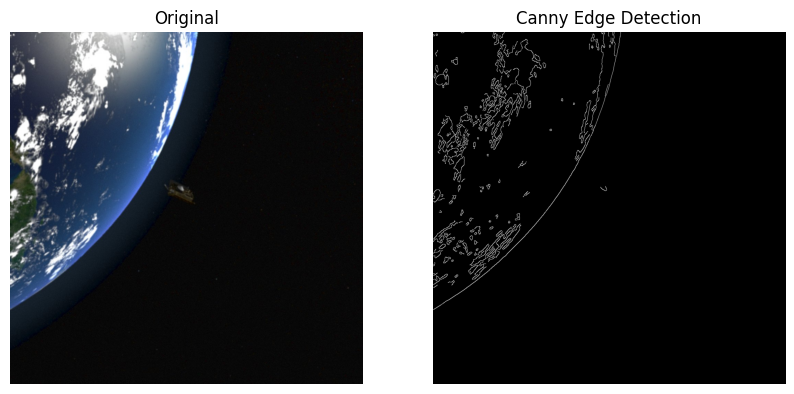

In [19]:
import cv2
import matplotlib.pyplot as plt

def load_and_detect_edges(path):
    # Load the image
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(image_gray, (5, 5), 0)

    # Canny Edge Detection
    canny = cv2.Canny(blurred, 100, 200)

    return image, canny

def display_images(images, titles):
    plt.figure(figsize=(10, 5))  # Adjust figure size for better visibility
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.title(title)
        if title == "Original":
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
        else:
            plt.imshow(img, cmap='gray')  # Display edge image in grayscale
        plt.axis('off')
    plt.show()

# Path to your local image
image_path = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/train/image_00006_Sentinel-6_2021.jpg'

# Load image and detect edges
original, canny = load_and_detect_edges(image_path)

# Display the images
display_images(
    [original, canny],
    ['Original', 'Canny Edge Detection']
)


## Contrast Enhancement

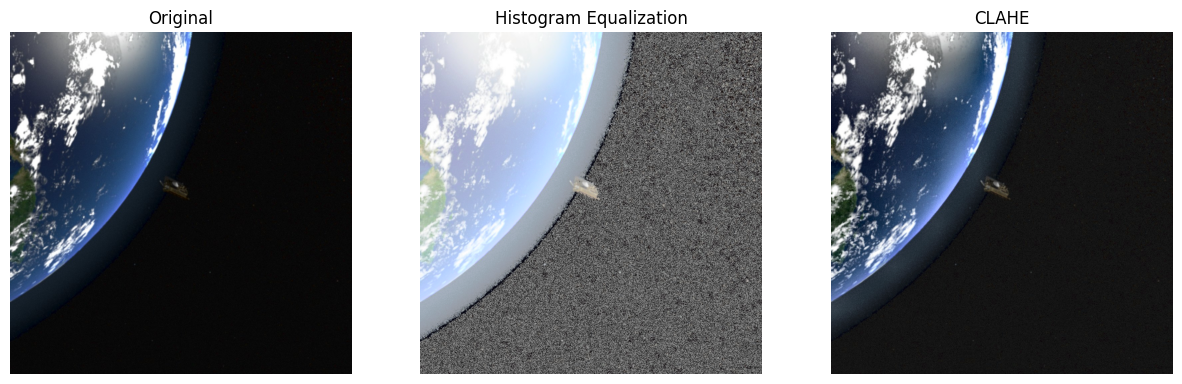

In [17]:
import cv2
import matplotlib.pyplot as plt

def enhance_contrast(image_path):
    # Load the image in color
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split the LAB image to L, A, and B channels
    l, a, b = cv2.split(lab)

    # Apply Histogram Equalization on the L-channel
    l_eq = cv2.equalizeHist(l)

    # Apply CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)

    # Merge the enhanced L-channel back with A and B channels
    lab_eq = cv2.merge((l_eq, a, b))
    lab_clahe = cv2.merge((l_clahe, a, b))

    # Convert back to RGB color space
    image_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)
    image_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    return image, image_eq, image_clahe

def display_images(images, titles):
    plt.figure(figsize=(15, 5))  # Enlarge figure for better visibility
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.title(title)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Correct color display
        plt.axis('off')
    plt.show()

# Path to your local image
image_path = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/train/image_00006_Sentinel-6_2021.jpg'

# Enhance contrast
original, histogram_eq, clahe_image = enhance_contrast(image_path)

# Display the images
display_images(
    [original, histogram_eq, clahe_image],
    ['Original', 'Histogram Equalization', 'CLAHE']
)


## Color space transformation


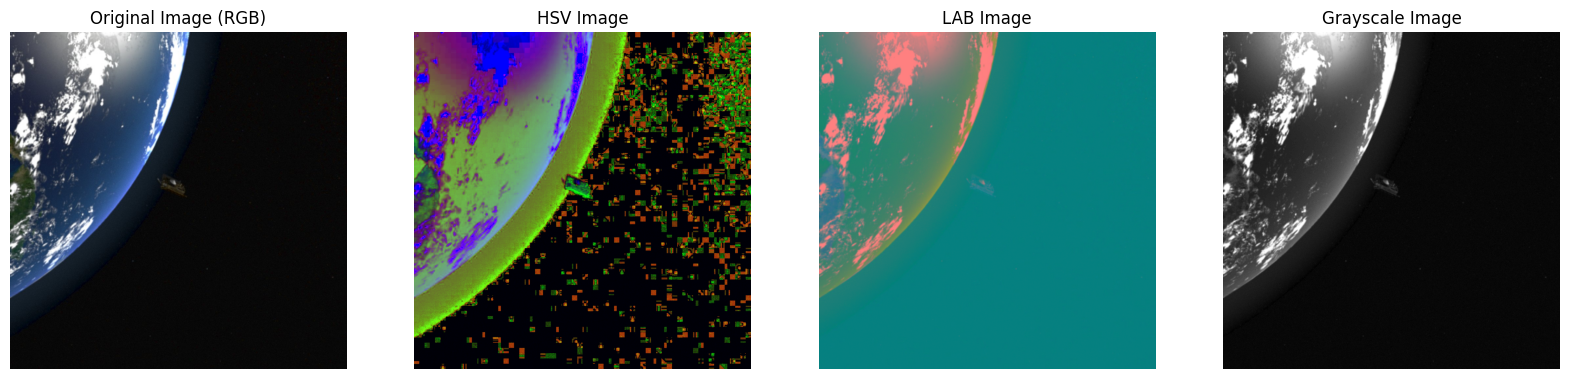

In [18]:
import cv2
import matplotlib.pyplot as plt

def load_and_transform_image(path):
    # Load the image
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display in matplotlib

    # hsv and grayscale can be reliable

    # Convert from RGB to HSV
    image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    # Convert from RGB to LAB
    image_lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2Lab)

    # Convert from RGB to Grayscale
    image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

    return image_rgb, image_hsv, image_lab, image_gray

def display_images(images, titles):
    plt.figure(figsize=(20, 10))
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.title(title)
        if len(img.shape) == 2:  # grayscale image
            plt.imshow(img, cmap='gray')
        else:  # color image
            plt.imshow(img)
        plt.axis('off')
    plt.show()

# Path to your local image
image_path = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/train/image_00006_Sentinel-6_2021.jpg'

# Load and transform the image
original, hsv, lab, gray = load_and_transform_image(image_path)

# Display the images
display_images(
    [original, hsv, lab, gray],
    ['Original Image (RGB)', 'HSV Image', 'LAB Image', 'Grayscale Image']
)


## loading all the images in tensor variable for pipeline(not required now)

In [11]:
# Initialize the ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Assuming the images are stored as follows
train_dir = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/train'
val_dir = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/val'

# Set the batch size and target image size
batch_size = 32
target_size = (150, 150)  # Adjust based on your model's input size requirements

# Prepare the data loader for training data using flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col="filename",  # Column in your DataFrame that contains the filenames
    y_col="class",  # Column in your DataFrame that contains the labels
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'  # Or 'categorical' for multi-class
)

# Similarly, you can set up a generator for validation data
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=val_dir,
    x_col="filename",
    y_col="class",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'  # Match this with the train_generator's class_mode
)


Found 41999 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


## Preprocessing

In [23]:
import cv2
import pandas as pd
import numpy as np
from pathlib import Path

label_path = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/labels.csv'

label = pd.read_csv(label_path)
train_df = label[label['usage'] == 'train'][['filename', 'class', 'bbox']].sample(frac = 1, random_state = 32)
val_df = label[label['usage'] == 'val'][['filename', 'class', 'bbox']].sample(frac = 1, random_state = 32)

# Assuming 'label' is the column with numerical values
train_df['class'] = train_df['class'].replace({1: 'satellite', 0: 'debris'})
val_df['class'] = val_df['class'].replace({1: 'satellite', 0: 'debris'})

train_dir = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/train'
val_dir = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/val'

def load_and_preprocess_image(image_path, target_size=(150, 150)):
    """
    Load an image from disk and apply basic preprocessing: resizing and normalization.
    
    Args:
        image_path (Path): Path to the image file.
        target_size (tuple): Desired output size of the image (width, height).
        
    Returns:
        numpy.ndarray: The preprocessed image.
    """
    # Load the image
    image = cv2.imread(str(image_path))
    # Resize the image
    image = cv2.resize(image, target_size)
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Normalize pixel values to [0, 1]
    image = image / 255.0
    return image

def load_images(df, base_dir, target_size=(150, 150)):
    """
    Load and preprocess all images specified in a DataFrame.
    
    Args:
        df (pandas.DataFrame): DataFrame containing the filenames of images to load.
        base_dir (Path): Base directory where the images are stored.
        target_size (tuple): Desired output size of the images (width, height).
        
    Returns:
        list: A list of preprocessed images.
    """
    images = []
    for filename in df['filename']:
        image_path = base_dir + '/' + filename
        image = load_and_preprocess_image(image_path, target_size)
        images.append(image)
    return np.array(images)

# Example usage
train_images = load_images(train_df, train_dir)
val_images = load_images(val_df, val_dir)

# Now train_images and val_images contain the preprocessed images


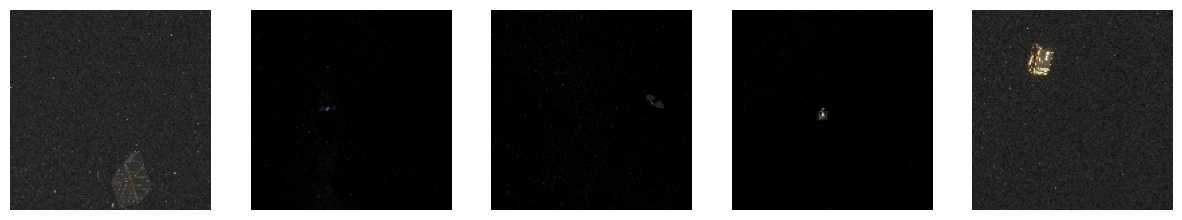

In [24]:
import matplotlib.pyplot as plt

def display_sample_images(images, num_samples=5):
    """
    Display a sample of images.
    
    Args:
        images (numpy.ndarray): An array of images.
        num_samples (int): Number of sample images to display.
    """
    if num_samples > len(images):
        num_samples = len(images)
        
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))
    
    for i in range(num_samples):
        ax = axes[i] if num_samples > 1 else axes
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

# Display sample images from the training set
display_sample_images(train_images)

# Optionally, display sample images from the validation set
# display_sample_images(val_images)


## denoising

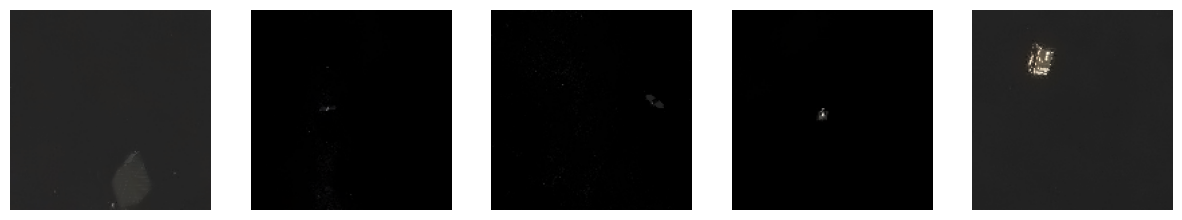

In [25]:
import cv2

def denoise_images(images):
    """
    Apply denoising to an array of images.
    
    Args:
        images (numpy.ndarray): An array of images to denoise.
        
    Returns:
        numpy.ndarray: The denoised images.
    """
    denoised_images = []
    for image in images:
        # Convert the image from [0, 1] back to [0, 255] and from float to uint8
        image_uint8 = (image * 255).astype('uint8')
        # Apply the denoising function
        denoised = cv2.fastNlMeansDenoisingColored(image_uint8, None, 10, 10, 7, 21)
        # Normalize and append to the list
        denoised_images.append(denoised.astype('float32') / 255.0)
    return np.array(denoised_images)


train_images_denoised = denoise_images(train_images)
val_images_denoised = denoise_images(val_images)


display_sample_images(train_images_denoised)


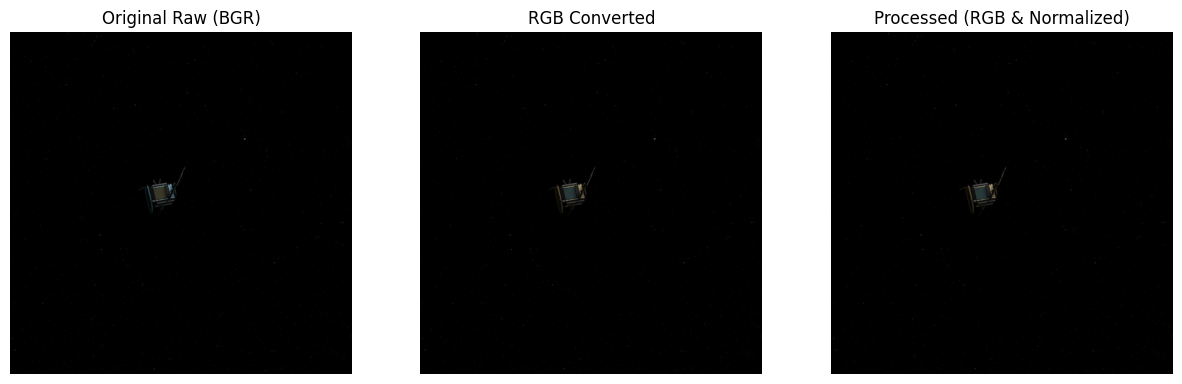

In [22]:
import cv2
import numpy as np

def convert_and_normalize(image):
    """
    Convert an image from BGR to RGB and normalize pixel values to [0, 1].
    
    Args:
        image (numpy.ndarray): Input image in BGR color space.
    
    Returns:
        numpy.ndarray: Processed image in RGB color space with pixel values normalized.
    """
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Normalize pixel values to [0, 1]
    image_normalized = image_rgb / 255.0
    return image_normalized


import matplotlib.pyplot as plt

# Load an image (replace 'path_to_your_image.jpg' with the actual file path)
image_path = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/train/image_00008_Cloudsat_2021.jpg'
image_bgr = cv2.imread(image_path)

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Apply the conversion and normalization function
processed_image = convert_and_normalize(image_bgr)

# Display the original raw (BGR), RGB converted, and processed images for comparison
plt.figure(figsize=(15, 5))

# Display original raw image (in BGR)
plt.subplot(1, 3, 1)
plt.imshow(image_bgr)
plt.title('Original Raw (BGR)')
plt.axis('off')

# Display RGB converted image
plt.subplot(1, 3, 2)
plt.imshow(image_rgb)
plt.title('RGB Converted')
plt.axis('off')

# Display processed (RGB converted and normalized) image
plt.subplot(1, 3, 3)
plt.imshow(processed_image)
plt.title('Processed (RGB & Normalized)')
plt.axis('off')

plt.show()



## Bounding box

In [2]:
import cv2
import pandas as pd
import ast 
import os

# Load the Excel file
label_path = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/labels.csv'

label = pd.read_csv(label_path)
train_df = label[label['usage'] == 'train'][['filename', 'class', 'bbox']].sample(frac = 1, random_state = 32)
val_df = label[label['usage'] == 'val'][['filename', 'class', 'bbox']].sample(frac = 1, random_state = 32)

# Assuming 'label' is the column with numerical values
train_df['class'] = train_df['class'].replace({1: 'satellite', 0: 'debris'})
val_df['class'] = val_df['class'].replace({1: 'satellite', 0: 'debris'})

# Directory where images are stored
train_image_folder = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/train/'
val_image_folder = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/val/'

dest_train_img_folder = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/preprocessed_data/train/'
dest_val_img_folder = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/preprocessed_data/val/'

def BoundingBox(df, read_folder, write_folder):

    for index, row in df.iterrows():
        img_path = read_folder + row['filename']
            
        image = cv2.imread(img_path)
        if isinstance(row['bbox'], str):
            bbox = ast.literal_eval(row['bbox'])
        else:
            bbox = row['bbox']
        y_min, x_min, y_max, x_max = bbox
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 1)  # Blue color box with 2 px thickness
    
        dest_img_path = write_folder + row['filename']
        cv2.imwrite(dest_img_path, image)


def delete_images_in_batches(directory, batch_size=1000):
    with os.scandir(directory) as entries:
        count = 0
        for entry in entries:
            if entry.is_file() and entry.name.endswith('.jpg'):
                os.remove(entry.path)
                count += 1
                if count % batch_size == 0:
                    print(f"Deleted {count} files so far...")
        print(f"Total deleted: {count}")


delete_images_in_batches(dest_train_img_folder)
BoundingBox(train_df, train_image_folder, dest_train_img_folder)
delete_images_in_batches(dest_val_img_folder)
BoundingBox(val_df, val_image_folder, dest_val_img_folder)

            

Total deleted: 0
Total deleted: 0


In [6]:
# # Create the 'images' directories inside 'train' and 'val' if they don't already exist
# !mkdir -p train/images
# !mkdir -p val/images

# # Move all .jpg files to the 'images' directory under 'train'
# !find train -maxdepth 1 -type f -name "*.jpg" -exec mv {} train/images/ \;

# # Move all .jpg files to the 'images' directory under 'val'
# !find val -maxdepth 1 -type f -name "*.jpg" -exec mv {} val/images/ \;

# !mkdir -p train/labels;
# !mkdir -p val/labels;

# !find train -type f -name "*.txt" -delete  

# !find val -type f -name "*.txt" -delete

find: train: No such file or directory
find: val: No such file or directory


In [10]:
import pandas as pd
import os
from PIL import Image

# # Create the 'images' directories inside 'train' and 'val' if they don't already exist
# mkdir -p train/images
# mkdir -p val/images

# # Move all .jpg files to the 'images' directory under 'train'
# find train -maxdepth 1 -type f -name "*.jpg" -exec mv {} train/images/ \;

# # Move all .jpg files to the 'images' directory under 'val'
# find val -maxdepth 1 -type f -name "*.jpg" -exec mv {} val/images/ \;

# mkdir -p train/labels;
# mkdir -p val/labels;

# Load the Excel file
label_path = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/labels.csv'

label = pd.read_csv(label_path)
train_df = label[label['usage'] == 'train'][['filename', 'class', 'bbox']].sample(frac = 1, random_state = 32)
val_df = label[label['usage'] == 'val'][['filename', 'class', 'bbox']].sample(frac = 1, random_state = 32)

# Assuming 'label' is the column with numerical values
train_df['class'] = train_df['class'].replace({1: 'satellite', 0: 'debris'})
val_df['class'] = val_df['class'].replace({1: 'satellite', 0: 'debris'})

# Directory where images are stored
train_image_folder = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/yolo_data/train/images/'
val_image_folder = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/yolo_data/val/images/'

train_label_folder = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/yolo_data/train/labels/'
val_label_folder = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/yolo_data/val/labels/'


# Check if the destination folder is not empty
if os.path.exists('/Users/nithish/Documents/Academics/Spring 24/AML/project/data/yolo_data/'):
    # Remove the entire directory and its contents
    shutil.rmtree('/Users/nithish/Documents/Academics/Spring 24/AML/project/data/yolo_data/')

def convert_boxes(df, image_folder, output_folder):
    
    # Iterate over the rows of the DataFrame
    for index, row in df.iterrows():
        filename = row['filename']
        
        if isinstance(row['bbox'], str):
            bbox = ast.literal_eval(row['bbox'])
        else:
            bbox = row['bbox']
            
        y_min, x_min, y_max, x_max = bbox
        
        # y_min, x_min, y_max, x_max = row['y_min'], row['x_min'], row['y_max'], row['x_max']
        
        # Construct full image path
        image_path = os.path.join(image_folder, filename)
        
        # Try to open the image and handle the case where the image is not found
        try:
            with Image.open(image_path) as img:
                width, height = img.size

                class_index = 0
                # Calculate normalized bounding box coordinates
                x_center = ((x_min + x_max) / 2) / width
                y_center = ((y_min + y_max) / 2) / height
                bbox_width = (x_max - x_min) / width
                bbox_height = (y_max - y_min) / height

                # Prepare label file content
                label_content = f"{class_index} {x_center} {y_center} {bbox_width} {bbox_height}\n"

                # Write to the corresponding label file
                label_filename = os.path.splitext(filename)[0] + '.txt'
                label_path = os.path.join(output_folder, label_filename)
                with open(label_path, 'a') as file:  # 'a' to append in case multiple boxes per image
                    file.write(label_content)

        except FileNotFoundError:
            print(f"Warning: {image_path} not found. Skipping.")
        except IOError:
            print(f"Error: Cannot open {image_path}. Skipping.")

# Example usage
convert_boxes(df = train_df, image_folder = train_image_folder, output_folder = train_label_folder)
convert_boxes(df = val_df, image_folder = val_image_folder, output_folder = val_label_folder)


In [21]:
# Import statements
import pandas as pd
import numpy as np

import os
import shutil

import zipfile


# Create a folder with a tree structure:
    # master_data
        # |- train
        # |- val
        # |- test


# to find different types of file extensions in a folder
#find . -type f -exec sh -c 'echo "${0##*.}"' {} \; | sort | uniq -c

# command for deleting faster in mac
# find . -maxdepth 1 -name "*.jpg" -exec rm {} \;    # go to the respective directory

# Check if the destination folder is not empty
if os.path.exists('/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/'):
    # Remove the entire directory and its contents
    shutil.rmtree('/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/')

#------------------------------CODE FOR PREPROCESSING 2021 DATASET-----------------------------------#

train_data = pd.read_csv('/Users/nithish/Documents/Academics/Spring 24/AML/project/data/ICIP-2021/labels/train_labels.csv')
val_data = pd.read_csv('/Users/nithish/Documents/Academics/Spring 24/AML/project/data/ICIP-2021/labels/validate_labels.csv')
test_data = pd.read_csv('/Users/nithish/Documents/Academics/Spring 24/AML/project/data/ICIP-2021/labels/test_labels.csv')

# Dropping unwanted columns
val_data.drop(['id', 'depth'], inplace = True, axis = 1)
train_data.drop(['id', 'depth'], inplace = True, axis = 1)
test_data.drop(['id', 'depth'], inplace = True, axis = 1)

# Function to check value_counts
def valueCounts(data, lst):
    for col in lst:
        print(col,'\n')
        print(data[col].value_counts())
        print('\n')

valueCounts(test_data, ['class'])
valueCounts(train_data, ['class'])
valueCounts(val_data, ['class'])

# It is confirmed that class `6` is debris in test dataset


# Class for Ordinal encoding - classes
order = {'CubeSat': 1,
 'Jason': 2,
 'TRMM': 3,
 'Cloudsat': 4,
 'Terra': 5,
 'Debris': 6,
 'Sentinel-6': 7,
 'AcrimSat': 8,
 'Aura': 9,
 'Aquarius': 10,
 'Calipso': 11}

# Preserving the original class names
train_data['class1'] = train_data['class'].copy()
val_data['class1'] = val_data['class'].copy()
test_data['class1'] = test_data['class'].copy()

# Ordinal encoding - classes
train_data['class'] = train_data['class'].map(order)
val_data['class'] = val_data['class'].map(order)


# Function that takes a random sample from each class of satillites(apart from debris) and merged with the filtered dataset of debris
# END GOAL OF THE FUNCTION: To have balanced no of records between debris and satellites
def stratifiedSampling(data, top):
    print(data.shape)
    WOdebris_data = data[data['class'] != 6]
    WOdebris_sampLst = []
    
    for col in WOdebris_data['class'].unique().tolist():
        
        col_temp_data = WOdebris_data[WOdebris_data['class'] == col].copy()
        
        col_temp_data = col_temp_data.sample(frac=1, random_state=102)
        col_temp_data = col_temp_data.head(top)
        WOdebris_sampLst.extend(col_temp_data.index.tolist())
    
    nonDebri_data = data.loc[WOdebris_sampLst]
    Debri_data = data[data['class'] == 6]
    
    Filtered_data = pd.concat([Debri_data, nonDebri_data], ignore_index=True)
    Filtered_data = Filtered_data.sample(frac=1, random_state=102)
    print(Filtered_data.shape)
    
    return Filtered_data


Filtered_train = stratifiedSampling(train_data, 1500)
Filtered_val = stratifiedSampling(val_data, 500)


# Label encoding with 0 (debris) and 1 (all the other satellites)
Filtered_train['class'] = Filtered_train['class'].apply(lambda x: 0 if x == 6 else 1)
Filtered_val['class'] = Filtered_val['class'].apply(lambda x: 0 if x == 6 else 1)
test_data['class'] = test_data['class'].apply(lambda x: 0 if x == 6 else 1)


# Appending satellite name and year to original image name, changing file extension and relocating it
def imageRenameRelocalize(data, tag):
    data['image_c'] = data['image'].str[:-7]
    data['image'] = data['image'].str[:-4]
    data['image'] = data['image'] + '.jpg'
    
    # counters for checking non-existing images
    found_count = 0
    not_found_count = 0
    
    for clas in data['class1'].unique().tolist():
        data.loc[data['class1'] == clas,'image_c'] = data[data['class1'] == clas]['image_c'] + clas + '_2021.jpg'
        for index, row in data[data['class1'] == clas].iterrows():
            
            actual_image_name = row['image']
            changing_image_name = row['image_c']

            original_image_path = os.path.join('/Users/nithish/Documents/Academics/Spring 24/AML/project/data/ICIP-2021/' + tag + '_rgb/' + clas, actual_image_name)
            destination_image_path = os.path.join('/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/' + tag, changing_image_name)
    
            try:
                # Copy the image file to another location
                shutil.copy(original_image_path, destination_image_path)
                found_count += 1
            except FileNotFoundError:
                not_found_count += 1
                data.drop([index], inplace = True, axis = 0)         

    print(tag, f"Files found: {found_count}")
    print(tag, f"Files not found: {not_found_count}")
    
    return data

Filtered_train = imageRenameRelocalize(Filtered_train, 'train')
Filtered_val = imageRenameRelocalize(Filtered_val, 'val')



# Appending year to original image name, changing file extension and relocating test dataset
def testImageRelocalize():
    test_data['image_c'] = test_data['image'].str[:-7]
    test_data['image'] = test_data['image'].str[:-4]
    test_data['image'] = test_data['image'] + '.jpg'

    found_count = 0
    not_found_count = 0
    
    test_data.loc[:,'image_c'] = test_data['image_c'] + '2021.jpg'
    for index, row in test_data.iterrows():
        
        actual_image_name = row['image']
        changing_image_name = row['image_c']

        original_image_path = os.path.join('/Users/nithish/Documents/Academics/Spring 24/AML/project/data/ICIP-2021/test_rgb', actual_image_name)
        destination_image_path = os.path.join('/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/test', changing_image_name)
    
        try:
            # Copy the image file to another location
            shutil.copy(original_image_path, destination_image_path)
            found_count += 1
        except FileNotFoundError:
            not_found_count += 1
            test_data.drop([index], inplace = True, axis = 0)

    print(f"Test Files found: {found_count}")
    print(f"Test Files not found: {not_found_count}")   

testImageRelocalize()



Filtered_train.drop(['class1', 'image'], inplace = True, axis = 1)
Filtered_val.drop(['class1', 'image'], inplace = True, axis = 1)
test_data.drop(['class1', 'image'], inplace = True, axis = 1)

Filtered_train['usage'] = 'train'
Filtered_val['usage'] = 'val'
test_data['usage'] = 'test'

Filtered_train['year'] = 2021
Filtered_val['year'] = 2021
test_data['year'] = 2021

test_data['illumination'] = np.nan

# Define the desired order of column names
desired_order = ['illumination', 'image_c', 'bbox', 'year', 'usage', 'class']

# Reorder the columns of the DataFrame
Filtered_train = Filtered_train[desired_order]
Filtered_val = Filtered_val[desired_order]
test_data = test_data[desired_order]

# Combining train, val and test
data_2021 = pd.concat([Filtered_train, Filtered_val, test_data], ignore_index=True)
data_2021.rename(columns={'image_c': 'filename'}, inplace=True)
data_2021.reset_index(drop=True, inplace=True)

# Exporting 2021 dataset
data_2021.to_csv('data/data_2021.csv', index=False)




#------------------------------CODE FOR PREPROCESSING 2022 DATASET-----------------------------------#

train = pd.read_csv('/Users/nithish/Documents/Academics/Spring 24/AML/project/data/spark-2022-stream-1/labels/train.csv')
test = pd.read_csv('/Users/nithish/Documents/Academics/Spring 24/AML/project/data/spark-2022-stream-1/labels/sample_submission.csv')
val = pd.read_csv('/Users/nithish/Documents/Academics/Spring 24/AML/project/data/spark-2022-stream-1/labels/val.csv')


# Function that takes a random sample from each class of satillites(apart from debris) and merged with the filtered dataset of debris
# END GOAL OF THE FUNCTION: To have balanced no of records between debris and satellites
def filter_train_val(data,flag):
    new_data = data[data['class']=='debris']
    list = data['class'].value_counts().index.tolist()
    list.remove('debris')
    
    class_df = pd.DataFrame()
    for class_name in list:
        if flag == 'train':
            Class = data[data['class'] == class_name].head(600)
        else:
            Class = data[data['class'] == class_name].head(200)
        class_df = pd.concat([class_df, Class])
    
    class_df = class_df.sample(frac=1, random_state=42)
    class_df.reset_index(drop=True, inplace=True)
    
    Filtered_data = pd.concat([new_data, class_df])
    Filtered_data = Filtered_data.sample(frac=1, random_state=42)
    Filtered_data.reset_index(drop=True, inplace=True)
    return Filtered_data


Filtered_train  = filter_train_val(train,'train')
Filtered_val = filter_train_val(val,'val')


# Appending year to original image name and changing file extension
Filtered_train['filename'] = Filtered_train['filename'].str[:-4]
Filtered_train['filename'] = Filtered_train['filename'] + '_2022.jpg'

Filtered_val['filename'] = Filtered_val['filename'].str[:-4]
Filtered_val['filename'] = Filtered_val['filename'] + '_2022.jpg'


# Label encoding with 0 (debris) and 1 (all the other satellites)
category_to_zero = 'debris'
Filtered_train['class'] = Filtered_train['class'].apply(lambda x: 0 if x == category_to_zero else 1)
Filtered_val['class'] = Filtered_val['class'].apply(lambda x: 0 if x == category_to_zero else 1)


# Relocating Images
def image_transfer(data,flag):
    filenames_data_df = pd.DataFrame() 
    filenames_data_df['filename'] = data['filename']
    
    if (flag == 'train'):
        folder_2022_train = "/Users/nithish/Documents/Academics/Spring 24/AML/project/data/spark-2022-stream-1/train"
        master_train_folder = "/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/train"
    else:
        folder_2022_val = "/Users/nithish/Documents/Academics/Spring 24/AML/project/data/spark-2022-stream-1/val"
        master_val_folder = "/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/val"
    
    for filename in filenames_data_df['filename']:    
        finalName = filename
        filename = filename[:-9]
        filename = filename +'.jpg'
        
        if (flag == 'train'):
            source_path = os.path.join(folder_2022_train, filename)
            destination_path = os.path.join(master_train_folder, finalName)
        else:
            source_path = os.path.join(folder_2022_val, filename)
            destination_path = os.path.join(master_val_folder, finalName)
        
        if os.path.exists(source_path):
            shutil.copy(source_path, destination_path)
    
    print("Images transferred.")


image_transfer(Filtered_train,'train')
image_transfer(Filtered_val,'val')


Filtered_train['usage'] = 'train'
Filtered_val['usage'] = 'val'
test['usage'] = 'test'

Filtered_train['year'] = 2022
Filtered_val['year'] = 2022
test['year'] = 2022

Filtered_train['illumination'] = np.nan
Filtered_val['illumination'] = np.nan
test['illumination'] = np.nan
test['bbox'] = np.nan
test['class'] = np.nan

# Define the desired order of column names
desired_order = ['illumination', 'filename', 'bbox', 'year','usage','class']

# Reorder the columns of the DataFrame
Filtered_train = Filtered_train[desired_order]
Filtered_val = Filtered_val[desired_order]
test = test[desired_order]

# Combining train, val and test
data_2022 = pd.concat([Filtered_train, Filtered_val, test], ignore_index=True)
data_2022.reset_index(drop=True, inplace=True)

# Exporting 2021 dataset
data_2022.to_csv('data/data_2022.csv', index=False)



#------------------------------MERGING TWO DATASETS 2021 AND 2022---------------------------------------#

concatenated_df = pd.concat([data_2021, data_2022], ignore_index=True)

concatenated_df.to_csv('/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/labels.csv', index=False)



#------------------------------ZIPPING MASTER FOLDER---------------------------------------#

def zip_folder(folder_path, zip_path):

    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

folder_to_zip = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data'  # Path to the folder to be zippe
zip_file_path = '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data.zip' # Path to the resulting zip file

zip_folder(folder_to_zip, zip_file_path)


class 

class
6     5000
1     2500
0     2500
7     2500
9     2500
8     2500
2     2500
5     2500
10    2500
3     2500
4     2500
Name: count, dtype: int64


class 

class
Debris        15000
CubeSat        7500
Jason          7500
TRMM           7500
Cloudsat       7500
Terra          7500
Sentinel-6     7500
AcrimSat       7500
Aura           7500
Aquarius       7500
Calipso        7500
Name: count, dtype: int64


class 

class
Debris        5000
Cloudsat      2500
Terra         2500
Sentinel-6    2500
CubeSat       2500
AcrimSat      2500
Aquarius      2500
TRMM          2500
Aura          2500
Calipso       2500
Jason         2500
Name: count, dtype: int64


(90000, 5)
(30000, 5)
(30000, 5)
(10000, 5)
train Files found: 0
train Files not found: 30000
val Files found: 0
val Files not found: 10000
Test Files found: 0
Test Files not found: 30000


FileNotFoundError: [Errno 2] No such file or directory: '/Users/nithish/Documents/Academics/Spring 24/AML/project/data/master_data/train/img027349_2022.jpg'